In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

In [2]:
from nltk.tokenize import word_tokenize
import re
from nltk.stem import PorterStemmer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import names
from collections import Counter
from tqdm import trange
import itertools

In [93]:
import pandas as pd
import numpy as np
import re
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Gensim
import gensim
from gensim.utils import simple_preprocess
# NLTK
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pprint import pprint
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
def nltk2wn_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:                    
        return None
def lemmatize_sentence(sentence):
    lem = WordNetLemmatizer()
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))    
    wn_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)
    res_words = []
    for word, tag in wn_tagged:
        if tag is None:                        
            res_words.append(word)
        else:
            res_words.append(lem.lemmatize(word, tag))
    return " ".join(res_words)

def preprocess_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'http\S+','',tweet)        # remove urls
    tweet = re.sub('[^a-z]',' ',tweet)
    tweet = lemmatize_sentence(tweet)

    tweet = word_tokenize(tweet)
    add_stop = ['religion','religious']

    #tweet = [ps.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    tweet = [word for word in tweet if not word in set(stopwords.words('english'))]
    tweet = [word for word in tweet if not word in set(names.words()) and not word in set(add_stop)]

    tweet = " ".join(tweet)
    return tweet

def preprocess_no_lem_stem(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'http\S+','',tweet)        # remove urls
    tweet = re.sub('[^a-z]',' ',tweet)

    tweet = word_tokenize(tweet)
    
    add_stop = ['religion','religious','religions']
    
    tweet = [word for word in tweet if not word in set(stopwords.words('english'))]
    tweet = [word for word in tweet if not word in set(names.words()) and not word in set(add_stop)]

    tweet = " ".join(tweet)
    return tweet


def find_hashtag(tweet): # return hashtage word only @ml -> ml + lowering
    r       = re.findall('#.[a-zA-z]*',tweet.lower())
    hashtags = []
    if len(r) > 0:
        for i in r:
            h = re.sub('#','',i)
            h = re.sub('[^a-zA-Z0-9]','',i)
            hashtags.append(h)
        return hashtags
    
def remove_link(tweet):
    tweet = re.sub(r'http\S+','',tweet)
    return tweet
    
def remove_hashtag(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
  
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

def remove_number(tweet):
    r = re.sub('[0-9]','',tweet)
    return r

def remove_users(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
  
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

#### calculate hashtag frequency

In [5]:
def top_n_hashtag(hashtags,stopwords,top_n=20):
    hashtags      = [hashtag for hashtag in hashtags if not hashtag in set(stopwords)]
    hashtags_dist = Counter(hashtags)
    
    hashtags_dist = np.column_stack([list(hashtags_dist.keys()),list(hashtags_dist.values())])
    hashtags_dist = pd.DataFrame(hashtags_dist,columns=['Hashtag','count'])
    
    hashtags_dist['count']=hashtags_dist['count'].astype(int)
    top_hashtag = hashtags_dist.nlargest(n=top_n,columns='count')
    return top_hashtag

#### calculate bigram frequency

In [6]:
def top_n_bigram(terms_bigram,top_n=20):
    bigrams = list(itertools.chain(*terms_bigram))
    bigrams_dist = Counter(bigrams)

    bigrams_dist = pd.DataFrame(bigrams_dist.most_common(25),columns=['Bigram','count'])
    
    join = lambda x:' - '.join(list(x))
    bigrams_dist['Bigram'] = list(map(join,bigrams_dist.Bigram))
    bigrams_dist['count']=bigrams_dist['count'].astype(int)
    top_bigram = bigrams_dist.nlargest(n=top_n,columns='count')
    return top_bigram

## Pre-processing

#### reading dataset

In [554]:
data = pd.read_csv('religion_pre.csv',index_col=2)
data.sample(2)

,index,text,pre
56,20964,my new religion is ur bangs. all i Care About ...,religion bangs care about life
59,5358,Entering contests to meet celebrities is bscly...,entering contests meet celebrities bscly religion


In [601]:
data.shape

(58027, 1)

#### remove duplicate -- as copy paste is popular on twitter

In [48]:
data.drop_duplicates(subset=['text'],keep='first',inplace=True)
data.index = np.arange(0,len(data))

#### some descriptive statistics

In [590]:
count = data['text'].str.split().str.len()

In [591]:
print(f'Total number of words : {count.sum()}')

Total number of words : 1423462


In [592]:
print(f'average words per tweet : {round(count.mean(),1)} words')

average words per tweet : 24.5 words


#### remove @USER

In [649]:
data['pre'] = np.vectorize(remove_users)(data['text'],"@ [\w]*", "@[\w]*")

#### Normalize -- lowering

In [650]:
data['pre'] = data['pre'].str.lower()

#### find hashtags

In [634]:
hashtags = []
for tweet in data.text:
    h = find_hashtag(tweet)
    if h:
        hashtags.append(h)

# merge lists
hashtags = list(itertools.chain.from_iterable(hashtags))

In [639]:
top_hashtags = top_n_hashtag(hashtags,stopwords=['religion','religions','religious',
                                                 '','1','whatiknowaboutislam','washingtonpost'],
                                                top_n=25)

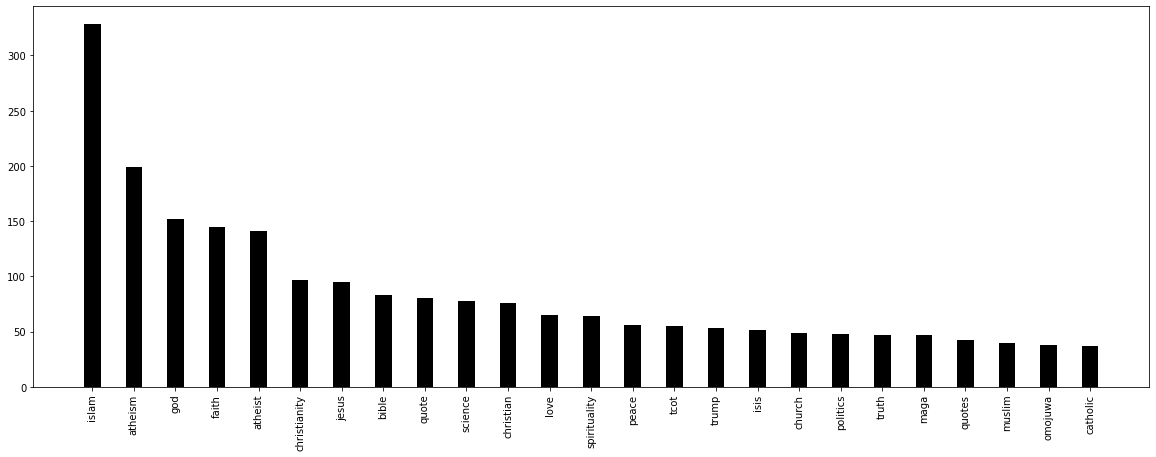

In [640]:
plt.figure(figsize=(20,7))
plt.bar(top_hashtags.Hashtag,top_hashtags['count'],color='black',width=0.4)
plt.xticks(rotation='vertical')
plt.show()

#### remove hashtags

In [654]:
data['pre'] = np.vectorize(remove_hashtag)(data['pre'],"# [\w]*", "#[\w]*")

#### remove links

In [655]:
data['pre'] = np.vectorize(remove_link)(data['pre'])

#### remove special characters -- only for topic modeling

In [656]:
data['pre'] = data['pre'].str.replace("[^a-zA-Z#]", " ")

c:\users\studa\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


#### REMOVE SHORT WORDS

In [62]:
custom_stopwords = ['religion','religions','religiuos','twitter']

In [658]:
data['pre'] = data['pre'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))

In [659]:
data['pre'] = data['pre'].apply(lambda x:' '.join([w for w in x.split() if not w in set(custom_stopwords)]))

#### keep only str instance (not nan,float,..)

In [660]:
data = data[data.pre.apply(lambda x: isinstance(x,str))]

### Religion wordcloud

In [663]:
tweets = [tweet for tweet in data.pre]
words  = ' '.join(tweets)

In [664]:
from PIL import Image
mask      = np.array(Image.open('twitter_mask.png'))
wordcloud = WordCloud(mask=mask,background_color='black',
                      colormap='Set2',random_state=1,stopwords=stopwords.words(),max_words=250).generate(words)

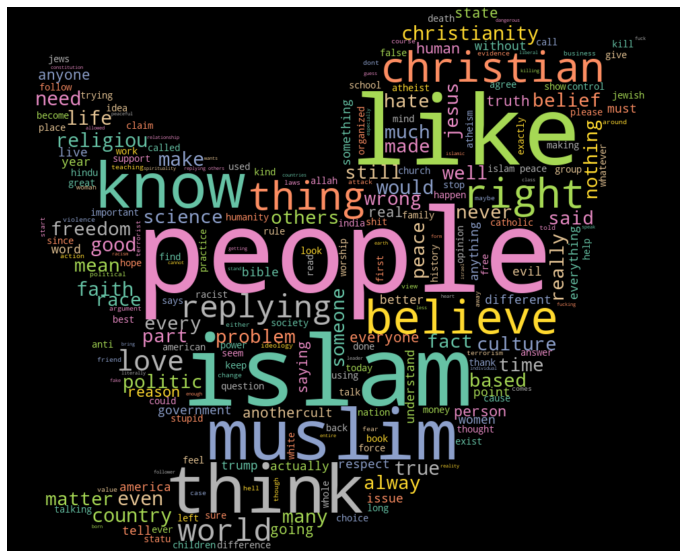

In [665]:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

### preprocessing phase result

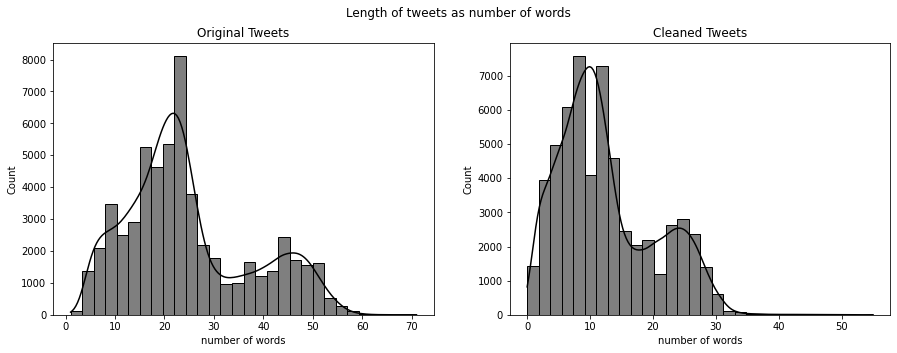

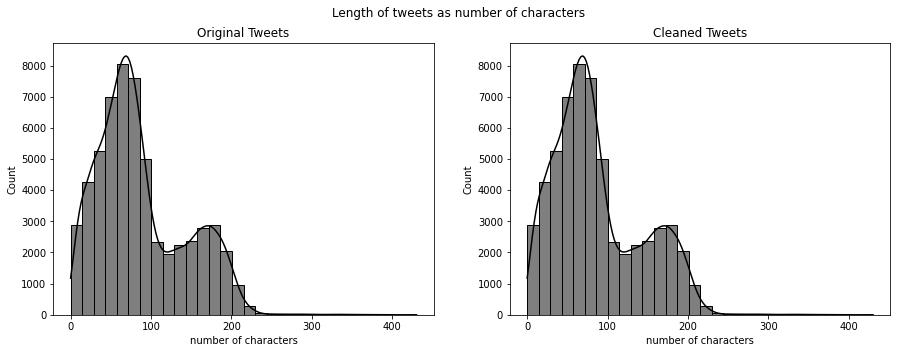

In [670]:
plt.figure(figsize=(15,5))
plt.suptitle('Length of tweets as number of words')

plt.subplot(1,2,1)
sns.histplot(data.text.str.split().str.len(),bins=30,kde=True,color='black',)
plt.title('Original Tweets')
plt.xlabel('number of words')

plt.subplot(1,2,2)
sns.histplot(data.pre.str.split().str.len(),bins=30,kde=True,color='black')
plt.title('Cleaned Tweets')
plt.xlabel('number of words')

plt.show()


plt.figure(figsize=(15,5))
plt.suptitle('Length of tweets as number of characters')
plt.subplot(1,2,1)
sns.histplot(data.pre.str.len(),bins=30,kde=True,color='black')
plt.title('Original Tweets')
plt.xlabel('number of characters')

plt.subplot(1,2,2)
sns.histplot(data.pre.str.len(),bins=30,kde=True,color='black')
plt.title('Cleaned Tweets')
plt.xlabel('number of characters')




plt.show()

#### descriptive statistics for Preprocessing phase

##### Original tweets as number of words

In [673]:
print(data.text.str.split().str.len().describe())

count    58027.000000
mean        24.531029
std         12.689009
min          1.000000
25%         16.000000
50%         22.000000
75%         31.000000
max         71.000000
Name: text, dtype: float64


##### Cleaned tweets as number of words

In [675]:
print(data.pre.str.split().str.len().describe())

count    58027.000000
mean        12.504024
std          7.658179
min          0.000000
25%          7.000000
50%         11.000000
75%         18.000000
max         55.000000
Name: pre, dtype: float64


In [736]:
df1 = pd.DataFrame(data.text.str.split().str.len())
df1['stat'] = 'original'

df2 = pd.DataFrame(data.pre.str.split().str.len())
df2['stat'] = 'cleaned'
df2.rename({'pre':'text'},inplace=True,axis=1)


In [738]:
df = pd.concat([df1,df2])
df

,text,stat
0,22,original
1,25,original
2,18,original
3,10,original
4,15,original
...,...,...
58022,10,cleaned
58023,4,cleaned
58024,9,cleaned
58025,27,cleaned


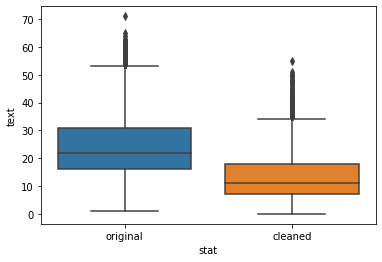

In [742]:
sns.boxplot(y=df.text,x=df.stat)
plt.show()

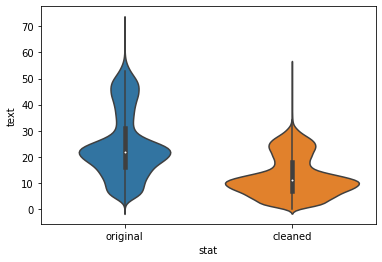

In [748]:
sns.violinplot(x=df.stat,y=df.text)
plt.show()

In [749]:
## preprocess -- remove stop words only for topic modeling -no stemming - no lemmitization

In [678]:
no_stop = []
for i in trange(len(data)):
    no_stop.append(preprocess_no_lem_stem(data.pre[i]))

100%|██████████████████████████████████████████████████████████████████████████| 58027/58027 [1:56:34<00:00,  8.30it/s]


In [752]:
data['no_stop'] = no_stop

In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(sentence,deacc=True)
data_words = list(sent_to_words(data.no_stop))

In [51]:
data['token_no_stop'] = data_words

c:\users\studa\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Bi-grams

In [ ]:
from nltk import bigrams
terms_bigram = [list(bigrams(tweet)) for tweet in data['token_no_stop']]

In [11]:
top_bigrams = top_n_bigram(terms_bigram,top_n=25)

In [1022]:
top_bigrams.drop(1,inplace=True) # drop wrong tweet -- 'replying - others '

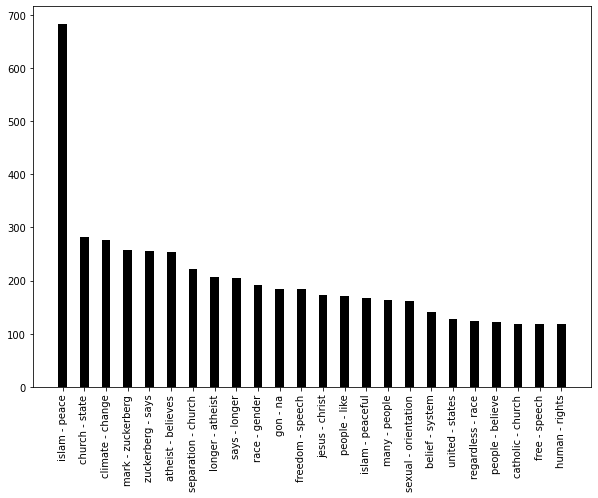

In [1023]:
plt.figure(figsize=(10,7))
plt.bar(top_bigrams['Bigram'],top_bigrams['count'],color='black',width=0.4)
plt.xticks(rotation=90)
plt.show()

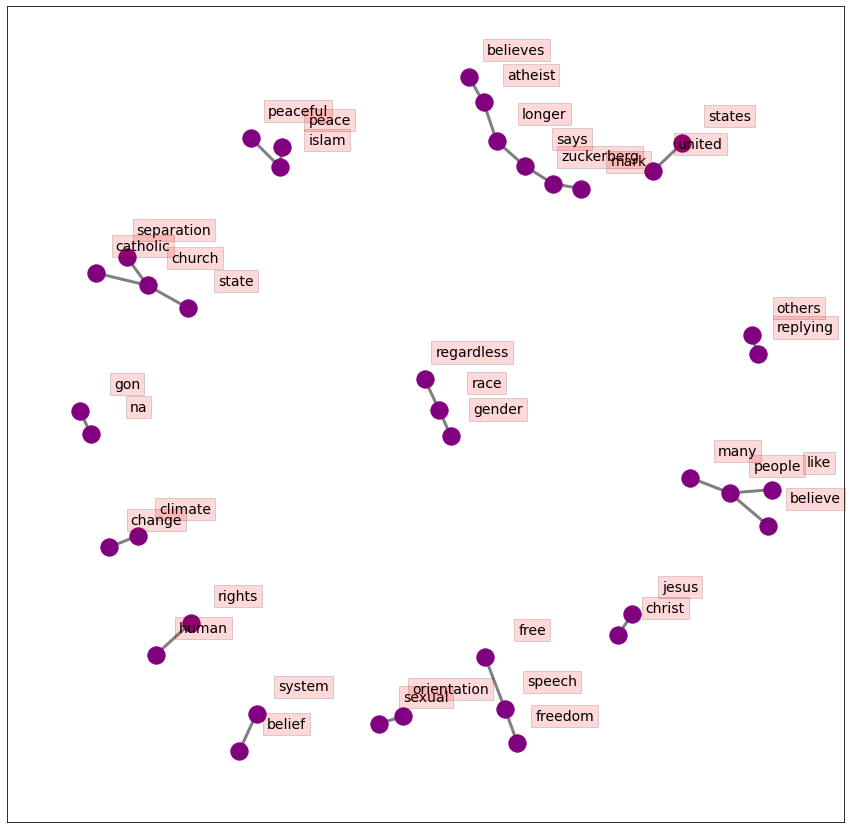

In [1046]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 5))

fig, ax = plt.subplots(figsize=(15, 15))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=10,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.065
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.15),
            horizontalalignment='center', fontsize=14)
    
plt.show()

### Topic modeling

In [22]:
# Build the bigram and trigram model
bigram = gensim.models.Phrases(data_words, min_count=10, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [23]:
print(trigram_mod[bigram_mod[data_words[5]]])

['plus', 'never', 'holier', 'regular', 'life', 'regular', 'life', 'includes', 'jokes', 'lore', 'joke']


In [24]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [25]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

In [30]:
def lemmatization(tweets,allowed_postags=['NOUN','VERB','ADJ','ADV']):
    nlp = spacy.load("en_core_web_sm",disable=['parser','ner']) # load model
    tweets_out = []
    for sent in tweets:
        doc = nlp(' '.join(sent))
        tweets_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return tweets_out

In [31]:
data['lemmatized'] = pd.Series(lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']))

#### Dropping Duplicates

In [41]:
# Join the tweet back together
def rejoin_words(row):
    words = row['lemmatized']
    joined_words = (" ".join(words))
    return joined_words

In [42]:
data['lemmatized_joined'] = data.apply(rejoin_words, axis=1)

c:\users\studa\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [43]:
data= data.drop_duplicates(subset=['lemmatized_joined'], keep='first', inplace=False)

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53402 entries, 0 to 57597
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               53402 non-null  object
 1   pre                53402 non-null  object
 2   no_stop            53402 non-null  object
 3   token_no_stop      53402 non-null  object
 4   lemmatized         53402 non-null  object
 5   lemmatized_joined  53402 non-null  object
 6   stemmed            53402 non-null  object
dtypes: object(7)
memory usage: 3.3+ MB


#### Stemming

In [45]:
stemmer = PorterStemmer()
data['stemmed'] = data['lemmatized'].apply(lambda x : [stemmer.stem(y) for y in x])

### LDA model

In [46]:
# Create Dictionary
id2word_stemmed = corpora.Dictionary(data['stemmed'])

In [47]:
# Create Dictionary
id2word_lemma = corpora.Dictionary(data['token_no_stop'])

In [39]:
# Term Document Frequency
corpus_stemmed = [id2word_stemmed.doc2bow(tweet) for tweet in data.stemmed]

In [48]:
[[(id2word_stemmed[id], freq) for id, freq in cp] for cp in corpus_stemmed[:3]]

[[('also', 1),
  ('bless', 1),
  ('blood', 1),
  ('deed', 1),
  ('fact', 1),
  ('full', 1),
  ('good', 1),
  ('islam', 1),
  ('life', 1),
  ('respect', 1)],
 [('disast', 1), ('human', 1), ('live', 1), ('piti', 2)],
 [('argu', 1), ('count', 1), ('peopl', 1), ('reason', 1)]]

In [51]:
# Build LDA model
lda_model_stemmed = gensim.models.ldamodel.LdaModel(corpus=corpus_stemmed,
                                           id2word=id2word_stemmed,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

In [52]:
pprint(lda_model_stemmed.print_topics())
doc_lda_stemmed = lda_model_stemmed[corpus_stemmed]

[(0,
  '0.027*"human" + 0.025*"state" + 0.024*"want" + 0.023*"world" + '
  '0.022*"faith" + 0.021*"polit" + 0.019*"countri" + 0.017*"differ" + '
  '0.014*"live" + 0.013*"current"'),
 (1,
  '0.070*"peopl" + 0.025*"thing" + 0.025*"good" + 0.020*"christian" + '
  '0.018*"control" + 0.017*"belief" + 0.015*"church" + 0.015*"also" + '
  '0.014*"grossli" + 0.014*"base"'),
 (2,
  '0.164*"repli" + 0.031*"other" + 0.022*"know" + 0.019*"free" + 0.017*"hindu" '
  '+ 0.016*"doubt" + 0.014*"distort" + 0.014*"love" + 0.013*"use" + '
  '0.012*"give"'),
 (3,
  '0.048*"think" + 0.033*"say" + 0.025*"worship" + 0.021*"littl" + '
  '0.020*"person" + 0.018*"life" + 0.018*"well" + 0.017*"true" + '
  '0.017*"freedom" + 0.016*"never"'),
 (4,
  '0.034*"believ" + 0.032*"make" + 0.026*"templ" + 0.023*"right" + '
  '0.020*"origin" + 0.018*"even" + 0.017*"pervers" + 0.016*"govern" + '
  '0.015*"need" + 0.015*"take"')]


### Sentiment Anlysis

In [70]:
data['sentiment'] = np.vectorize(remove_link)(data.text)
data['sentiment'] = np.vectorize(remove_hashtag)(data.sentiment,"# [\w]*", "#[\w]*")
data['sentiment'] = np.vectorize(remove_users)(data.sentiment,"@ [\w]*", "@[\w]*")
data['sentiment'] = data['sentiment'].apply(lambda x:' '.join([w for w in x.split() if not w in set(custom_stopwords)]))

In [73]:
data.drop_duplicates(subset=['sentiment'], keep='first', inplace=True)

In [117]:
df = data[~data.sentiment.str.contains('Retweeted')]

In [123]:
# Create an object of Vader Sentiment Analyzer
vader_analyzer = SentimentIntensityAnalyzer()

negative = []
neutral = []
positive = []
compound = []

def sentiment_scores(df, negative, neutral, positive, compound):
    for i in df['sentiment']:
        sentiment_dict = vader_analyzer.polarity_scores(i)
        negative.append(sentiment_dict['neg'])
        neutral.append(sentiment_dict['neu'])
        positive.append(sentiment_dict['pos'])
        compound.append(sentiment_dict['compound'])

# Function calling 
sentiment_scores(df, negative, neutral, positive, compound)

In [124]:
# Prepare columns to add the scores later
df["negative"] = negative
df["neutral"] = neutral
df["positive"] = positive
df["compound"] = compound

c:\users\studa\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\studa\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\studa\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be

In [131]:
sentiment = []
for i in df['compound']:
    if i >= 0.05 : 
        sentiment.append(1)
  
    elif i <= - 0.05 : 
        sentiment.append(-1) 
        
    else : 
        sentiment.append(0)
df['sentiment'] = sentiment

c:\users\studa\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [132]:
neg_tweets = df.sentiment.value_counts()[-1]
neu_tweets = df.sentiment.value_counts()[0]
pos_tweets = df.sentiment.value_counts()[1]

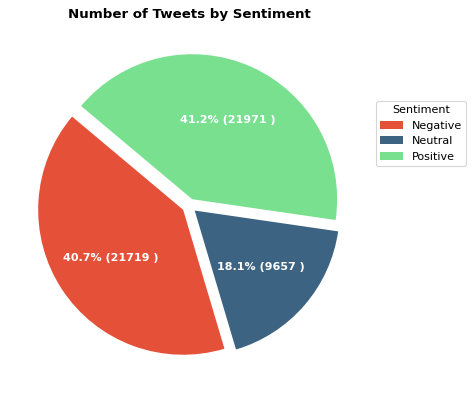

In [341]:
# Draw Plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"), dpi= 80)

data = [df.sentiment.value_counts()[-1], df.sentiment.value_counts()[0], df.sentiment.value_counts()[1]]
categories = ['Negative', 'Neutral', 'Positive']
explode = [0.05,0.05,0.05]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=['#e55039', '#3c6382', '#78e08f'],
                                  startangle=140,
                                  explode=explode)

# Decoration
ax.legend(wedges, categories, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0.2, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Number of Tweets by Sentiment", fontsize=12, fontweight="bold")
plt.show()

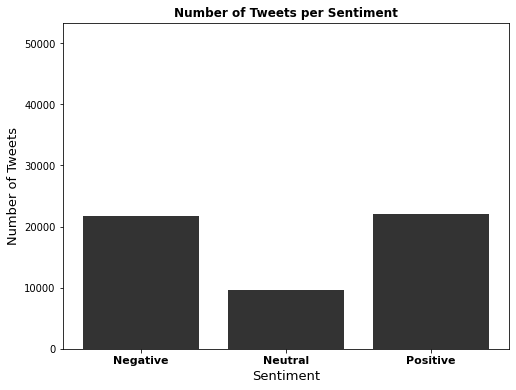

In [143]:
labels = ['Negative', 'Neutral', 'Positive']
freq = [df.sentiment.value_counts()[-1], df.sentiment.value_counts()[0], df.sentiment.value_counts()[1]]
index = np.arange(len(freq))

plt.figure(figsize=(8,6))
plt.bar(index, freq, alpha=0.8, color= 'black')
plt.xlabel('Sentiment', fontsize=13)
plt.ylabel('Number of Tweets', fontsize=13)
plt.xticks(index, labels, fontsize=11, fontweight="bold") 
plt.title('Number of Tweets per Sentiment', fontsize=12, fontweight="bold")
plt.ylim(0, len(df['text']))
plt.show()

In [164]:
df.drop(['token_no_stop'], axis=1, inplace=True)

c:\users\studa\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Neg. tweets

In [166]:
df_pos = df[df['sentiment']==1]
df_neg = df[df['sentiment']==(-1)]

In [168]:
# Join the tweet back together
def rejoin_words(row):
    words = row['lemmatized']
    joined_words = (" ".join(words))
    return joined_words

In [172]:
df_neg['no_stop_joined'] = df_neg.apply(rejoin_words, axis=1)

c:\users\studa\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [174]:
word_freq = pd.Series(np.concatenate([x.split() for x in df_neg.no_stop_joined])).value_counts()

In [175]:
word_df = pd.Series.to_frame(word_freq)
word_df['word'] = list(word_df.index)
word_df.reset_index(drop=True, inplace=True)
word_df.columns = ['freq', 'word']

In [176]:
word_df.drop([ 0, 1], inplace=True)

Unique words: 16533


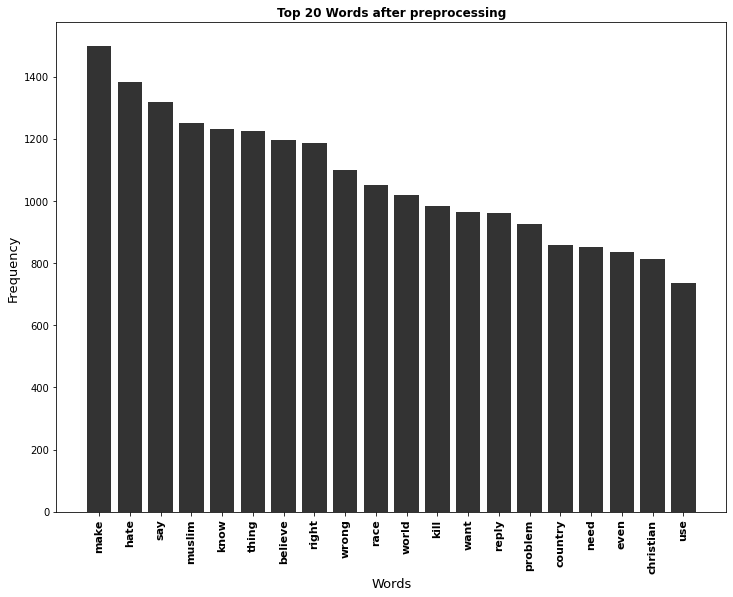

In [178]:
label = word_df['word'].head(20)
freq = word_df['freq'].head(20)
index = np.arange(len(freq))

print("Unique words:", len(word_df))
plt.figure(figsize=(12,9))
plt.bar(index, freq, alpha=0.8, color= 'black')
plt.xlabel('Words', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(index, label, fontsize=11, rotation=90, fontweight="bold") 
plt.title('Top 20 Words after preprocessing', fontsize=12, fontweight="bold")
plt.show()

#### Positive Tweets

In [181]:
df_pos['no_stop_joined'] = df_pos.apply(rejoin_words, axis=1)

word_freq_pos = pd.Series(np.concatenate([x.split() for x in df_pos.no_stop_joined])).value_counts()

word_df_pos = pd.Series.to_frame(word_freq_pos)
word_df_pos['word'] = list(word_df_pos.index)
word_df_pos.reset_index(drop=True, inplace=True)
word_df_pos.columns = ['freq', 'word']

In [182]:
word_df_pos.drop([0,2], inplace=True)

Unique words: 17028


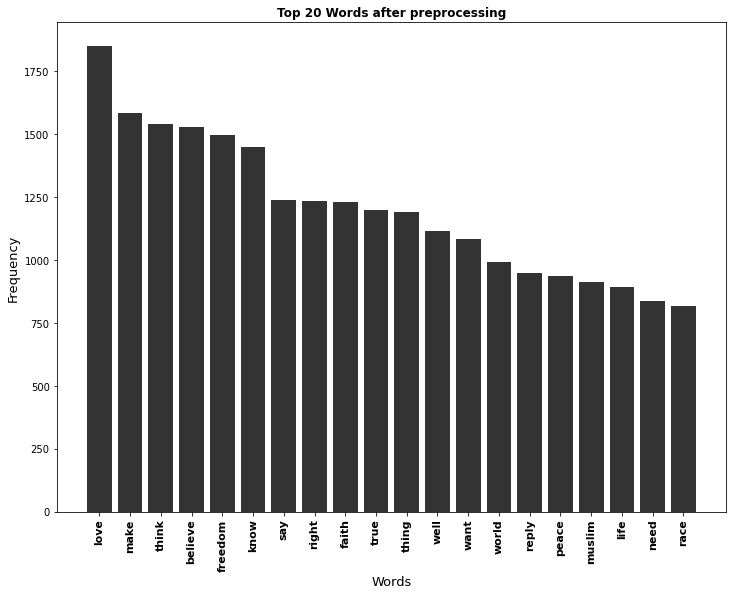

In [184]:
label = word_df_pos['word'].head(20)
freq = word_df_pos['freq'].head(20)
index = np.arange(len(freq))

print("Unique words:", len(word_df_pos))
plt.figure(figsize=(12,9))
plt.bar(index, freq, alpha=0.8, color= 'black')
plt.xlabel('Words', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(index, label, fontsize=11, rotation=90, fontweight="bold") 
plt.title('Top 20 Words after preprocessing', fontsize=12, fontweight="bold")
plt.show()

### WordCloud

In [185]:
all_words_pos = ' '.join([text for text in df_pos.apply(rejoin_words, axis=1)])
all_words_neg = ' '.join([text for text in df_neg.apply(rejoin_words, axis=1)])

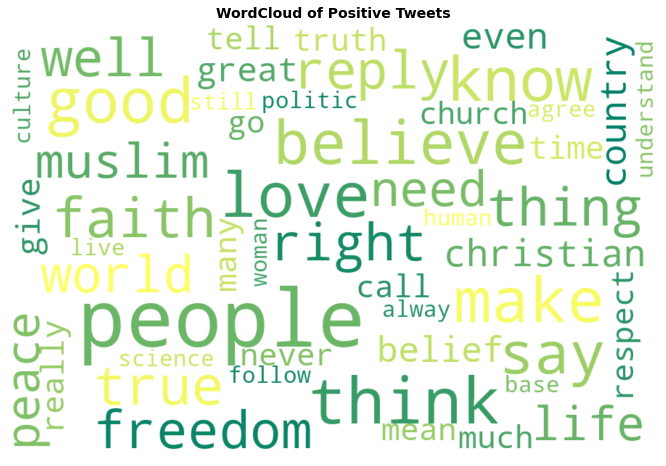

In [189]:
wordcloud = WordCloud(width=900, height=600,stopwords=stopwords.words(), random_state=21, max_font_size=110, background_color='white', 
                      max_words=50,colormap='summer').generate(all_words_pos)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Positive Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

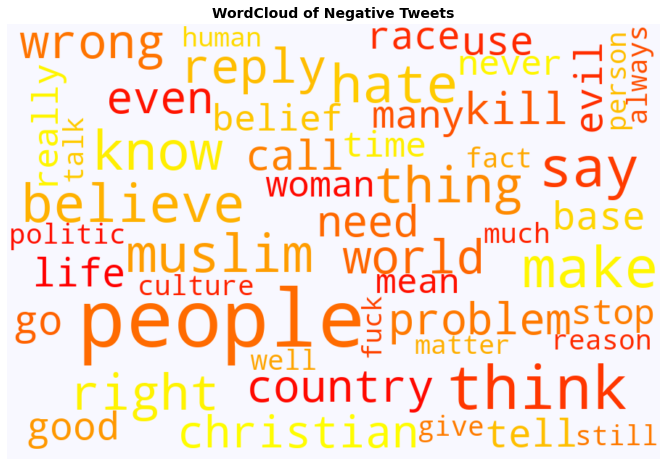

In [190]:
wordcloud = WordCloud(width=900,stopwords=stopwords.words(), height=600, random_state=21, max_font_size=110, background_color='ghostwhite', 
                      max_words=50,colormap='autumn').generate(all_words_neg)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Negative Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Tweets class distribution

In [200]:
print(df_pos.compound.describe())

count    21971.000000
mean         0.524153
std          0.240383
min          0.050300
25%          0.340000
50%          0.526700
75%          0.722700
max          0.993200
Name: compound, dtype: float64


In [201]:
print(df_neg.compound.describe())

count    21719.000000
mean        -0.542534
std          0.247835
min         -0.991600
25%         -0.755600
50%         -0.553000
75%         -0.340000
max         -0.050500
Name: compound, dtype: float64


### Top 10 +ve and -ve tweets

In [213]:
df_pos.sort_values('compound', inplace=True, ascending=False)
df_pos.reset_index(drop=True, inplace=True)

c:\users\studa\appdata\local\programs\python\python37\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [232]:
for tweet in df_pos.text.head(10):
    print(tweet)
    print('-------------')

Religion tells you to clean yourself up, then God will love you, but that’s not real love. That’s conditional love. Real love of God is not dependent on how much you love Him; it’s about how much He loves you. God love you unconditionally, His love cleanses all of your sin & dirt
-------------
Well, here in # Scotland, I cannot say I am very religious, spiritual is better word for me, but I do believe in kindness, be kind to all, like many and love a few, be needed and wanted by those you love, kindness will bring you happiness. Whatever your religion, race or creed
-------------
Religion tells you to clean yourself up, then God will love you, but that’s not real love. That’s conditional love. Real love is not dependent on how much you love Him; it’s about how much He loves you.
-------------
willrichmond mar mine would tolerant atheism fine left wing anarchist kind council coms may considered interested history fantasy must like tolerate metal accepting like going much appreciation fo

In [215]:
df_neg.sort_values('compound', inplace=True)
df_neg.reset_index(drop=True, inplace=True)

c:\users\studa\appdata\local\programs\python\python37\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [233]:
for tweet in df_neg.text.head(10):
    print(tweet)
    print('-------------')

mitch dead hand jan replying bs beth hate hate jews killed jeebus hate catholics bc hate witches hate muslims hate pagans hate h hate non believers hate mormons everybody else mostly hate bc worthy bc genocide onthe
-------------
Faking a hate crime should be considered a hate crime. The reason to fake a hate crime is to spread hate toward a race or religion to cause further division in America, therefore it is a hate crime and should be treated as such.
-------------
Religion caused the division of India and the formation of Pakistan. Hinduism versus Buddhism. Ban religion. That's the cause of so much death, killing, torture, abuse, rape, pain and suffering. There is no religion in India or Pakistan. Period. Take all books, etc.
-------------
That's what they live for. The desalination of all others but Muslims.The religion of hate, murder, rape, war, pedophilia.Islam is pure evil
-------------
You use that the way you use fear and religion & those killed by anyone who is an immagrant

### Checking Islam,Cristianity topics

In [275]:
word_df[word_df.word.isin(['islam','muslim','christian','christianity'])]

,freq,word
5,1252,muslim
20,813,christian
192,185,christianity
1064,33,islam


In [276]:
word_df_pos[word_df_pos.word.isin(['islam','muslim','christian','christianity'])]

,freq,word
18,913,muslim
23,778,christian
150,232,christianity
957,37,islam


In [312]:
df_neg.drop_duplicates(subset=['text'],keep='first',inplace=True)
df_neg.index = np.arange(0,len(df_neg))

c:\users\studa\appdata\local\programs\python\python37\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [316]:
df_pos.drop_duplicates(subset=['text'],keep='first',inplace=True)
df_pos.index = np.arange(0,len(df_pos))

### negative tweets

#### Islam - Muslim

In [300]:
df_islam_neg = df_neg[df_neg.text.str.contains('islam','muslim')].sort_values(by='compound')

In [301]:
for tweet in df_islam_neg.head(10).text:
    print(tweet)
    print(' ------------------ ')

In wars, killing as we please are also prohibited, there are so many restrictions about war in islam and it is a last resort. All those stupid people they call themselves ISIS are idiots, they kill just bcs killing, they strayed away from what the religion says
 ------------------ 
andrew richardson ba nov anti muslim persecution racism islamophobia fear different things confused persecuting someone based race already unlawful critical mocking islam blasphemy unlawful never novara media nov expected anti muslim hatred became mp also knew exactly whipping new report proves right
 ------------------ 
Obama is delusional. This is not A religion of peace. It is one that behead and commits terroristic acts all over the world including 911 and many more terroristic act's in our country. Obama is a disgusting disgrace who has sold his soul to the devil! https://nypost.com/2015/02/18/obama-defends-the-true-peaceful-nature-of-islam/ …
 ------------------ 
All criminals r terrorists ,Since terro

#### Christian - Christianity

In [302]:
df_christian_neg = df_neg[df_neg.text.str.contains('christian','christianity')].sort_values(by='compound')

In [303]:
for tweet in df_christian_neg.head(10).text:
    print(tweet)
    print(' ------------------ ')

Christ is dead too you know, but I hear y'all, the last thing we need is another bullshit religion pushing even worse laws than the previous. Islam is the worst of the worst. I believe in no god but would stand besides christians to fight this threat against our freedoms
 ------------------ 
fuck christianity, fuck religion, i cant believe god is real, christianity is a fucked up thing that is forced on you, from birth and you’re just told to “have faith”, and made to feel bad and “sinful” if you don’t. fuck that. i’ll believe in god when he stops doing shitty
 ------------------ 
mar scottytherapistprotector fine rape fine rape christianity call rape sin rape mentioned ten commandments rape woman girl pay father silver lnpprotectrapists
 ------------------ 
Disagree all u want, but u are wrong. He is leader of deception. Democrats are anti christian/pro Islam-religion of war and death.
 ------------------ 
Even the unradicalized christians cause pain too. Just look at those pathetic s

### postive tweets

#### Islam - Muslim

In [308]:
df_islam_pos = df_pos[df_pos.text.str.contains('islam','muslim')].sort_values(by='compound',ascending=False)
for tweet in df_islam_pos.head(10).text:
    print(tweet)
    print(' ------------------ ')

thats true, iran is a great country and deserves its glory. but islam isnt the problem. that would be like me assuming that christianity is the problem because the kkk exists. the extremists of the religion have gained power and mixed government with religion. that’s the problem.
 ------------------ 
Islam is the religion of peace and love we muslims never hurt other religions and their sentiments by making fun of there famous persons infact we muslims give respect to every community either Christian, indians or someone else we give respect.Correct your views regarding islam.
 ------------------ 
We only claim to be muslims by physical appearance in most cases but hardly is our spiritual life islamic...how can this happen where 95% are from a religion that only preaches peace n love with everyone...things like these hurts..may Allah 4gv her n us in General Ameen
 ------------------ 
emilia mar islam still promotes kidnapping christian children sex slavery via people say muslim peace lo

### Christian - Christianity

In [309]:
df_christian_pos = df_pos[df_pos.text.str.contains('christian','christianity')].sort_values(by='compound',ascending=False)
for tweet in df_christian_pos.head(10).text:
    print(tweet)
    print(' ------------------ ')

willrichmond mar mine would tolerant atheism fine left wing anarchist kind council coms may considered interested history fantasy must like tolerate metal accepting like going much appreciation forests feb gf rules christian preferably methodist orthodox anti state nature lover shy tomboy goth close guy friends bonus points average attractiveness actual requirements anyone likes probably accept gladly
 ------------------ 
gerry mccann jul often full unnecessary rules regulations threats punishments god like infinite love set free life god love peace harmony christian meditation golden rule love mini podcast bible meditations selfhelpforyoursuccess com christian meditation golden rule love unsure deal people golden rule makes easy simply asks would like golden rule alone develops loving authentic relationships
 ------------------ 
thats true, iran is a great country and deserves its glory. but islam isnt the problem. that would be like me assuming that christianity is the problem becaus

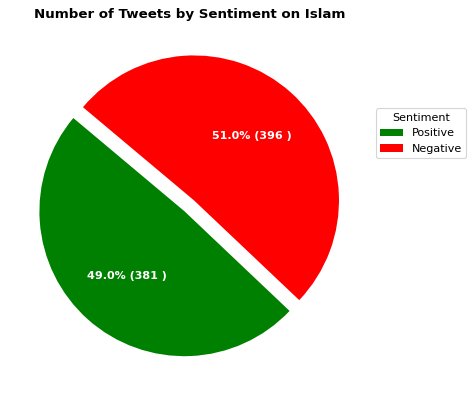

In [349]:
# Draw Plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"), dpi= 80)

data = [len(df_islam_pos.sentiment), len(df_islam_neg.sentiment)]
categories = ['Positive','Negative']
explode = [0.05,0.05]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=['green', 'red'],
                                  startangle=140,
                                  explode=explode)

# Decoration
ax.legend(wedges, categories, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0.2, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Number of Tweets by Sentiment on Islam", fontsize=12, fontweight="bold")
plt.show()

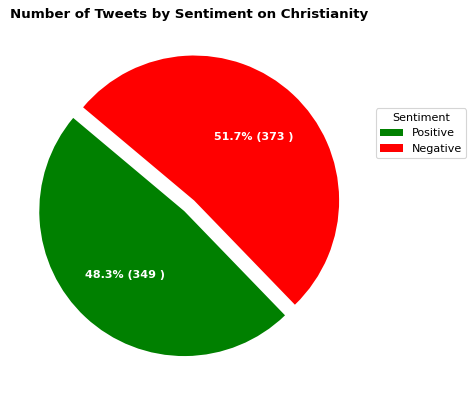

In [350]:
# Draw Plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"), dpi= 80)

data = [len(df_christian_pos.sentiment), len(df_christian_neg.sentiment)]
categories = ['Positive','Negative']
explode = [0.05,0.05]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=['green', 'red'],
                                  startangle=140,
                                  explode=explode)

# Decoration
ax.legend(wedges, categories, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0.2, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Number of Tweets by Sentiment on Christianity", fontsize=12, fontweight="bold")
plt.show()

In [323]:
df.to_pickle('df.pkl')
df_pos.to_pickle('df_pos.pkl')
df_neg.to_pickle('df_neg.pkl')